### Importing all the necessary library

In [1]:
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
#import xgboost as xgb
from wordcloud import WordCloud
from collections import Counter
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

## Loading data from the Sentiment Data Frame

In [111]:
# Loading data from the provided sentiment dataset
df = pd.read_csv('sentiment_analysis.csv')
df.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3,1


In [3]:
# removing ID cloumn from the data frame as it is of no use
df=df[['label','text']]
df.head()

,label,text
0,1,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0
1,1,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…
2,1,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…"
3,1,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…"
4,1,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3


In [112]:
# Getting general information from the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550391 entries, 0 to 550390
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      550391 non-null  float64
 1   text    550391 non-null  object 
 2   label   550391 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 12.6+ MB


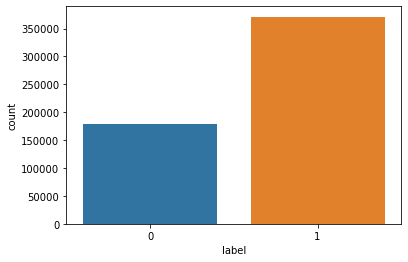

In [110]:
#Plotting graph from the dataframe provided
sns.countplot(x = 'label', data = df)

Looking at the graph, positive sentiment is in larger proportion

In [6]:
# Since the rows counts is too much to process with my system so the dataframe is spliced out randomly till 100000 rows
# considering the anaylsis should not be deviated much.

train=df[0:100000] #Sliced first 100000 rows 

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   100000 non-null  int64 
 1   text    100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


### Pre-Processing/Cleaning of Data
Issue with text data is that it is all in text format (strings). However, Machine learning algorithms need  numerical feature vector in order to perform the task. 

#### Data Cleaning

In [113]:
train.shape #shape of the dataset

(100000, 3)


#### Removing unwanted text patterns from the tweets

In [9]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt


#### 1. Removing Twitter Handles (@user)

In [10]:
train['clean_tweet'] = np.vectorize(remove_pattern)(train['text'], "@[\w]*") 
train.head()

,label,text,clean_tweet
0,1,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0
1,1,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…,RT : Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…
2,1,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…","RT : This September, is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…"
3,1,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…","RT : Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…"
4,1,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3,RT : Excited to announce: as of July 2017 Feschotte lab will be relocating to MBG https://t.co/dd0FG7BRx3


#### 2. Removing Punctuations, Numbers, and Special Characters

In [11]:
train['clean_tweet'] = train['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
train.head()

,label,text,clean_tweet
0,1,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https t co antImqAo Y https t co ejnA Sks
1,1,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…,RT Congratulations Pakistan on becoming #No TestTeam in the world against all odds #JI PakZindabadRallies https t co o
2,1,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…",RT This September is taking you to Maine Mendoza s surprise thanksgiving party she threw for her fans https t co oX
3,1,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…",RT Newly painted walls thanks a million to our custodial painters this summer Great job ladies #EC proud https t co
4,1,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3,RT Excited to announce as of July Feschotte lab will be relocating to MBG https t co dd FG BRx


#### 3. Removing Short Words

In [12]:
train['clean_tweet'] = train['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
train.head()

,label,text,clean_tweet
0,1,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,Josh Jenkins looking forward Breeders Crown Super Sunday https antImqAo https ejnA
1,1,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…,Congratulations Pakistan becoming TestTeam world against odds PakZindabadRallies https
2,1,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…",This September taking Maine Mendoza surprise thanksgiving party threw fans https
3,1,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…",Newly painted walls thanks million custodial painters this summer Great ladies proud https
4,1,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3,Excited announce July Feschotte will relocating https


#### 4. Removing https

In [13]:
train['clean_tweet'] = train['clean_tweet'].str.replace('https', " ")
train.head()

,label,text,clean_tweet
0,1,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,Josh Jenkins looking forward Breeders Crown Super Sunday antImqAo ejnA
1,1,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…,Congratulations Pakistan becoming TestTeam world against odds PakZindabadRallies
2,1,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…",This September taking Maine Mendoza surprise thanksgiving party threw fans
3,1,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…",Newly painted walls thanks million custodial painters this summer Great ladies proud
4,1,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3,Excited announce July Feschotte will relocating


#### 5. Text Normalization (Tokenization: Used to describe the process of converting the normal text strings into a list of tokens i.e. words that we actually want)

In [14]:
tokenized_tweet = train['clean_tweet'].apply(lambda x: x.split()) 
tokenized_tweet.head()

0                    [Josh, Jenkins, looking, forward, Breeders, Crown, Super, Sunday, antImqAo, ejnA]
1            [Congratulations, Pakistan, becoming, TestTeam, world, against, odds, PakZindabadRallies]
2                [This, September, taking, Maine, Mendoza, surprise, thanksgiving, party, threw, fans]
3    [Newly, painted, walls, thanks, million, custodial, painters, this, summer, Great, ladies, proud]
4                                               [Excited, announce, July, Feschotte, will, relocating]
Name: clean_tweet, dtype: object

#### 6. Stemming (Reduction of inflected (or sometimes derived) words to their stem, base or root form - generally a written word form.i.e. "Stems", "Stemming", "Stemmed", "and Stemtization" results to "stem)

In [15]:
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()


0               [josh, jenkin, look, forward, breeder, crown, super, sunday, antimqao, ejna]
1                  [congratul, pakistan, becom, testteam, world, against, odd, pakzindabadr]
2                 [thi, septemb, take, main, mendoza, surpris, thanksgiv, parti, threw, fan]
3    [newli, paint, wall, thank, million, custodi, painter, thi, summer, great, ladi, proud]
4                                              [excit, announc, juli, feschott, will, reloc]
Name: clean_tweet, dtype: object

In [16]:
# Adding the stemmed and tokenized data back to dataframe
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
train['clean_tweet'] = tokenized_tweet
train.head()

,label,text,clean_tweet
0,1,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,josh jenkin look forward breeder crown super sunday antimqao ejna
1,1,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…,congratul pakistan becom testteam world against odd pakzindabadr
2,1,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…",thi septemb take main mendoza surpris thanksgiv parti threw fan
3,1,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…",newli paint wall thank million custodi painter thi summer great ladi proud
4,1,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3,excit announc juli feschott will reloc


## Visualization/EDA

#### Sentiment analysis : Visualizing the training data through words of clouds representation, where the higher frequencies words are shown in larger font

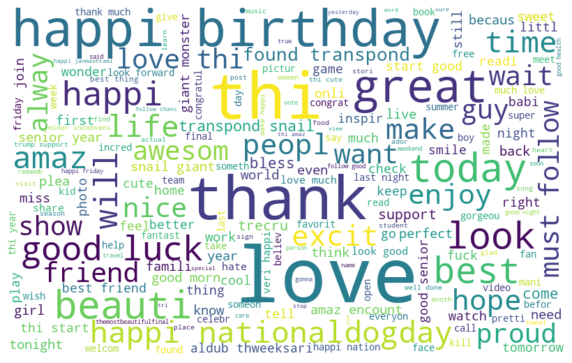

In [96]:
def plot_wordCloud(words):
    wordcloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=110).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    
# All clean data set representation
all_words = ' '.join([text for text in train['clean_tweet']])
plot_wordCloud(all_words)    

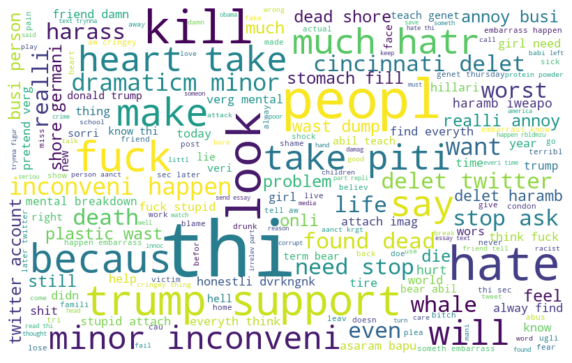

In [97]:
# Negative tweets
negative_tweets =' '.join([text for text in train['clean_tweet'][train['label'] == 0]])
plot_wordCloud(negative_tweets)

Negative Tweet from sentiment dataset: Major words looks like Kill,trump,hate,fuck,stop,harass etc

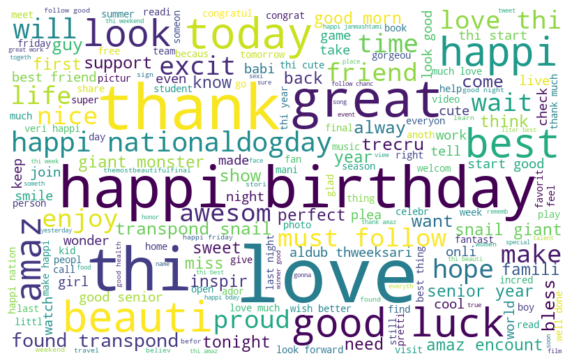

In [109]:
# Positive tweets
positive_words = ' '.join([text for text in train['clean_tweet'][train['label'] == 1]])
plot_wordCloud(positive_words)

Positive Tweet from sentiment dataset: Major words looks like thank,happi,love,good,luck etc

#### Hashtag Analysis

In [20]:
# Defining the function for the hashtag analysis
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags


In [21]:
# extracting hashtags from negative tweets

HT_neg = hashtag_extract(train['clean_tweet'][train['label'] == 0])

# extracting hashtags from positive tweets
HT_pos = hashtag_extract(train['clean_tweet'][train['label'] == 1])

# unnesting list
HT_neg = sum(HT_neg,[])
HT_pos = sum(HT_pos,[])

[Text(0.5, 1.0, 'Negative Tweets')]

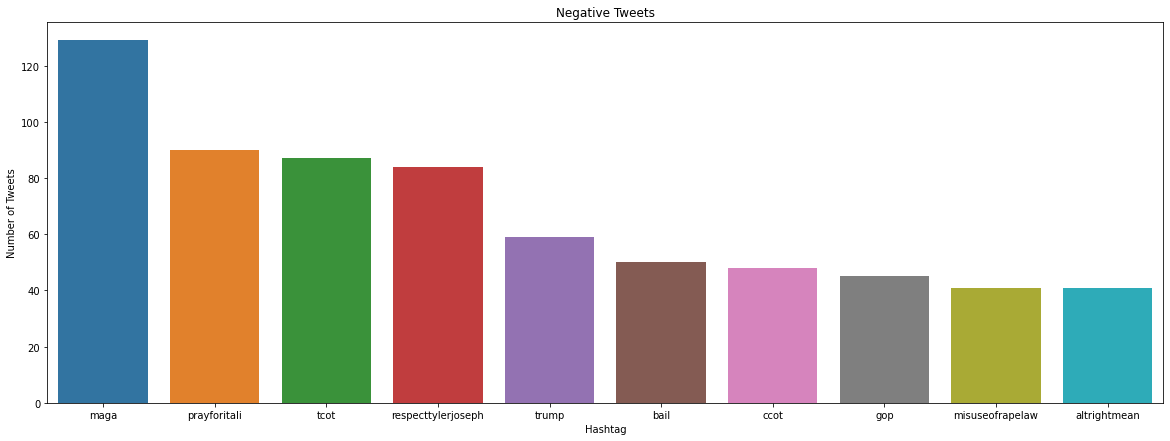

In [103]:
# Plotting graph for the negative hashtags
a = nltk.FreqDist(HT_neg)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(20,7))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Number of Tweets')
ax.set(title = 'Negative Tweets')

Major negative tweet hashtag includes concerning the election is trump, showing bad impression for the republic party

[Text(0.5, 1.0, 'Positive Tweets')]

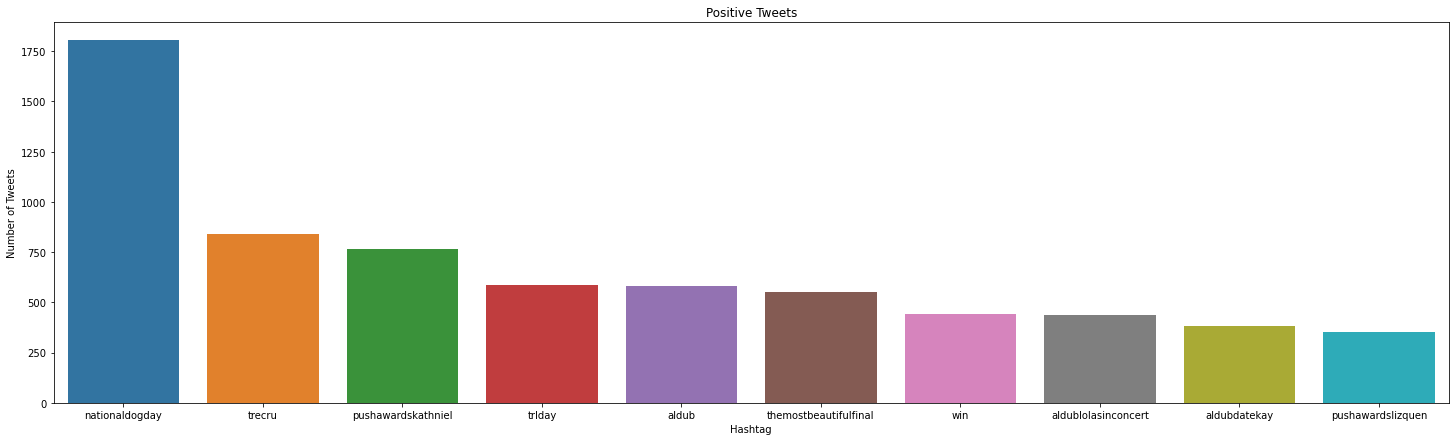

In [102]:
# Plotting graph for the positive hashtags
a = nltk.FreqDist(HT_pos)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 15 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(25,7))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Number of Tweets')
ax.set(title = 'Positive Tweets')

### Conclusion: In the training data set,  trump is being used as negative sentiment impacting the sentiment of people as they are not happy with the trump administration. While considering positive sentiment, there is some emotions oriented trends like national dog day, nothing concerning election prediction

## Features Extracting
### Bag Of Words Feature

In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity

In [24]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')
bow = bow_vectorizer.fit_transform(train['clean_tweet'])

### TF-IDF Feature

Some words have high frequency in large text corpus but makes very little meaningful information. If we use the count data directly to train a model, the very frequent tokens with little meaning will have a significant influence over the low frequency but far more interesting terms. So it is necessary to normalize and re-weight the word count result.

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(train['clean_tweet'])

## Model Building/Preparation

### 1. Logistics Regression

#### Bag Of Words Feature

In [26]:
train_bow = bow[:110000,:] # training set 


# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [27]:
xtrain_bow.shape

(70000, 2000)

In [28]:
lreg_bow = LogisticRegression() # model assigned

In [29]:
lreg_bow.fit(xtrain_bow, ytrain) # training the model

predicted_l1 = lreg_bow.predict(xvalid_bow) # predicting on the validation set

print(metrics.classification_report(yvalid, predicted_l1)) #creating classification data

print ('confusion matrix')
print (confusion_matrix(yvalid,predicted_l1)) # creating confusion matrix


              precision    recall  f1-score   support

           0       0.94      0.86      0.90      4697
           1       0.97      0.99      0.98     25303

    accuracy                           0.97     30000
   macro avg       0.96      0.93      0.94     30000
weighted avg       0.97      0.97      0.97     30000

confusion matrix
[[ 4049   648]
 [  243 25060]]


#### TF-IDF Feature

In [30]:
train_tfidf = tfidf[:110000,:]  #training set


# splitting data into training and validation set
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(train_tfidf, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)


In [31]:
lreg_l2 = LogisticRegression()

In [32]:
lreg_l2.fit(xtrain_tfidf, ytrain) # training the model

predicted_l2 = lreg_l2.predict(xvalid_tfidf) # predicting on the validation set

print(metrics.classification_report(yvalid, predicted_l2)) #creating classification data


print ('confusion matrix')
print (confusion_matrix(yvalid,predicted_l2)) # creating confusion matrix


              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4697
           1       0.97      0.99      0.98     25303

    accuracy                           0.97     30000
   macro avg       0.96      0.91      0.93     30000
weighted avg       0.97      0.97      0.97     30000

confusion matrix
[[ 3893   804]
 [  193 25110]]


Executing same procedure for different classifiers

### 2. Naive Bayes

#### Bag Of Words Feature

In [33]:
model_NB = BernoulliNB()

In [34]:
model_NB.fit(xtrain_bow, ytrain) # training the model

predict_NB = model_NB.predict(xvalid_bow)

print(metrics.classification_report(yvalid, predict_NB))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_NB))


              precision    recall  f1-score   support

           0       0.91      0.81      0.86      4697
           1       0.97      0.98      0.98     25303

    accuracy                           0.96     30000
   macro avg       0.94      0.90      0.92     30000
weighted avg       0.96      0.96      0.96     30000

confusion matrix
[[ 3809   888]
 [  381 24922]]


#### TF-IDF Feature

In [35]:
model_NB.fit(xtrain_tfidf, ytrain)

BernoulliNB()

In [36]:
model_NB_tfidf = model_NB.predict(xvalid_tfidf)

print(metrics.classification_report(yvalid, model_NB_tfidf))
print ('confusion matrix')
print (confusion_matrix(yvalid,model_NB_tfidf))


              precision    recall  f1-score   support

           0       0.91      0.81      0.86      4697
           1       0.97      0.98      0.98     25303

    accuracy                           0.96     30000
   macro avg       0.94      0.90      0.92     30000
weighted avg       0.96      0.96      0.96     30000

confusion matrix
[[ 3809   888]
 [  381 24922]]


### 3. Support Vector Machine (SVM)

#### Bag Of Word Feature

In [37]:
svc_bow = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

In [38]:
predict_svc_bow = svc_bow.predict(xvalid_bow)

print(metrics.classification_report(yvalid, predict_svc_bow))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_svc_bow))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      4697
           1       0.98      0.99      0.98     25303

    accuracy                           0.97     30000
   macro avg       0.96      0.93      0.94     30000
weighted avg       0.97      0.97      0.97     30000

confusion matrix
[[ 4057   640]
 [  276 25027]]


#### TF-IDF Feature

In [39]:
svc_tfidf = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

In [40]:
predict_svc_tfidf = svc_tfidf.predict(xvalid_tfidf)

print(metrics.classification_report(yvalid, predict_svc_tfidf))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_svc_tfidf))

              precision    recall  f1-score   support

           0       0.94      0.85      0.90      4697
           1       0.97      0.99      0.98     25303

    accuracy                           0.97     30000
   macro avg       0.96      0.92      0.94     30000
weighted avg       0.97      0.97      0.97     30000

confusion matrix
[[ 4015   682]
 [  244 25059]]


### 4. Random Forest

#### Bag Of Word Feature

In [41]:
rf_bow = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

In [42]:
predict_rf_bow = rf_bow.predict(xvalid_bow)

print(metrics.classification_report(yvalid, predict_rf_bow))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_rf_bow))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4697
           1       0.98      0.98      0.98     25303

    accuracy                           0.97     30000
   macro avg       0.93      0.94      0.94     30000
weighted avg       0.97      0.97      0.97     30000

confusion matrix
[[ 4219   478]
 [  548 24755]]


#### TF-IDF Feature

In [43]:
rf_tfidf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

In [44]:
predict_rf_tfidf = rf_tfidf.predict(xvalid_tfidf)

print(metrics.classification_report(yvalid, predict_rf_tfidf))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_rf_tfidf))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      4697
           1       0.98      0.99      0.98     25303

    accuracy                           0.97     30000
   macro avg       0.95      0.93      0.94     30000
weighted avg       0.97      0.97      0.97     30000

confusion matrix
[[ 4130   567]
 [  372 24931]]


### 5. XGBoost

#### Bag of Word Feature

In [45]:
# My MAC OS does not support this particular XGboost install and i tried a lot but it did not worked. So using 
# gradient boosting as a classifier as of now, please consider it
from sklearn.ensemble import GradientBoostingClassifier

xgb_bow = GradientBoostingClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)

In [46]:
predict_xgb_bow = xgb_bow.predict(xvalid_bow)

print(metrics.classification_report(yvalid, predict_xgb_bow))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_xgb_bow))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      4697
           1       0.97      0.99      0.98     25303

    accuracy                           0.97     30000
   macro avg       0.97      0.92      0.94     30000
weighted avg       0.97      0.97      0.97     30000

confusion matrix
[[ 3946   751]
 [  138 25165]]


#### TF-IDF Feature

In [47]:
xgb_tfidf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

In [48]:
predict_xgb_tfidf = xgb_tfidf.predict(xvalid_tfidf)

print(metrics.classification_report(yvalid, predict_xgb_tfidf))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_xgb_tfidf))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      4697
           1       0.98      0.99      0.98     25303

    accuracy                           0.97     30000
   macro avg       0.95      0.93      0.94     30000
weighted avg       0.97      0.97      0.97     30000

confusion matrix
[[ 4130   567]
 [  372 24931]]


### 6. K-NN

#### Bag Of Word Feature

In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn_bow = KNeighborsClassifier().fit(xtrain_bow, ytrain)

In [50]:
predict_knn_bow = knn_bow.predict(xvalid_bow)

print(metrics.classification_report(yvalid, predict_knn_bow))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_knn_bow))

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      4697
           1       0.93      0.99      0.96     25303

    accuracy                           0.93     30000
   macro avg       0.92      0.81      0.85     30000
weighted avg       0.93      0.93      0.93     30000

confusion matrix
[[ 2960  1737]
 [  332 24971]]


#### TF-IDF Feature

In [51]:
knn_tfidf = KNeighborsClassifier().fit(xtrain_tfidf, ytrain)

In [52]:
predict_knn_tfidf = knn_tfidf.predict(xvalid_tfidf)

print(metrics.classification_report(yvalid, predict_knn_tfidf))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_knn_tfidf))

              precision    recall  f1-score   support

           0       0.80      0.59      0.68      4697
           1       0.93      0.97      0.95     25303

    accuracy                           0.91     30000
   macro avg       0.87      0.78      0.82     30000
weighted avg       0.91      0.91      0.91     30000

confusion matrix
[[ 2775  1922]
 [  678 24625]]


### 7. Decision Tree

#### Bag Of Word Feature

In [53]:
from sklearn import tree

dt_bow = tree.DecisionTreeClassifier().fit(xtrain_bow, ytrain)

In [54]:
predict_dt_bow = dt_bow.predict(xvalid_bow)


print(metrics.classification_report(yvalid, predict_dt_bow))

print ('confusion matrix')
print (confusion_matrix(yvalid,predict_dt_bow))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4697
           1       0.98      0.97      0.97     25303

    accuracy                           0.96     30000
   macro avg       0.91      0.93      0.92     30000
weighted avg       0.96      0.96      0.96     30000

confusion matrix
[[ 4143   554]
 [  771 24532]]


#### TF-IDF

In [55]:
dt_tfidf = KNeighborsClassifier().fit(xtrain_tfidf, ytrain)

In [56]:
predict_dt_tfidf = dt_tfidf.predict(xvalid_tfidf)

print(metrics.classification_report(yvalid, predict_dt_tfidf))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_dt_tfidf))

              precision    recall  f1-score   support

           0       0.80      0.59      0.68      4697
           1       0.93      0.97      0.95     25303

    accuracy                           0.91     30000
   macro avg       0.87      0.78      0.82     30000
weighted avg       0.91      0.91      0.91     30000

confusion matrix
[[ 2775  1922]
 [  678 24625]]


### Since the performance accuracy of the models logistic regression, SVM, XGboost and Randon Forest is approximatley same ~97%, thus performing Hyper parameter tuning only on the random forest model as the accuarcy is quite high and need not to perform on multiple hypreparameter tuning on different models

In [57]:
#importing modules
from sklearn.model_selection import GridSearchCV

#making the instance
rf_bow_=RandomForestClassifier()

#hyper parameters set
params = {'criterion':['gini','entropy'],
          'n_estimators':[10,15,20,25,30],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7], 
          'random_state':[123],
          'n_jobs':[-1]}

#Making models with hyper parameters sets
rf_bow_tune = GridSearchCV(rf_bow, param_grid=params, n_jobs=-1)

#learning
rf_bow_tune.fit(xtrain_bow, ytrain)

#The best hyper parameters set
print("Best Hyper Parameters:\n",rf_bow_tune.best_params_)

#Prediction
predict_rf_tune=rf_bow_tune.predict(xvalid_bow)

#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(yvalid, predict_rf_tune))

#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(yvalid,predict_rf_tune))

Best Hyper Parameters:
 {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 30, 'n_jobs': -1, 'random_state': 123}
Accuracy: 0.9718333333333333
Confusion Metrix:
 [[ 4191   506]
 [  339 24964]]


In [58]:
# Final model which maximum accuracy

rf_bow_=RandomForestClassifier(criterion= 'entropy', min_samples_leaf= 1, min_samples_split=7, n_estimators= 30, n_jobs= -1, random_state= 123)

### US Election Data Set

In [59]:
# Loading the testing data
df_US=pd.read_csv('US_Elections_2020.csv')
df_US.head()

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! Even if #BidenHarris2020 win...frump has 3 months to do even more damage than he has.'",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery - a new initiative to promote #AnotherWay to deal with #Covid. Hysteria and rushed laws",0,others
2,"b'RT @WalidPhares: Uber Timing: after #Biden advisors said they would put pressure on #Brazil &amp; sanction @jairbolsonaro Gov ""when"" elected,",0,covid19
3,b'Every 107 seconds an American is dying from the #TrumpVirus \n\n#DonaldTrump thinks that is a success.\n\n#JoeBiden https://t.co/BlJRIl6VpN',1,NaN
4,b'RT @thewebbix: The #Democrats embrace #DiversityandInclusion for all citizens that make our nation what it is. Each of us must #Vote to,1,NaN


### Preprocessing/Cleaning
#### Performing same pre-processing technique on the test dataset to make sure the dimensions will be same as of trained model. Impleting the same procedure as of prior done on the training data

In [60]:
#Removing unwanted text patterns from the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

# 1. Removing Twitter Handles (@user)

df_US['clean_tweet'] = np.vectorize(remove_pattern)(df_US['text'], "@[\w]*") 

# 2. Removing Punctuations, Numbers, and Special Character

df_US['clean_tweet'] = df_US['clean_tweet'].str.replace("[^a-zA-Z#]", " ")

# 3. Removing Short Words
df_US['clean_tweet'] = df_US['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# 4. Removing https
df_US['clean_tweet'] = df_US['clean_tweet'].str.replace('https', " ")

# 5. Text Normalization
tokenized_tweet = df_US['clean_tweet'].apply(lambda x: x.split()) 

#6. Stemming
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
df_US['clean_tweet'] = tokenized_tweet

df_US.head()


,text,sentiment,negative_reason,clean_tweet
0,"b'@robreiner so afraid of Nov, Dec, and Jan! Even if #BidenHarris2020 win...frump has 3 months to do even more damage than he has.'",0,covid19,afraid even #bidenharri frump month even more damag than
1,"b""RT @SueC00K: Lord Sumption launches Recovery - a new initiative to promote #AnotherWay to deal with #Covid. Hysteria and rushed laws",0,others,lord sumption launch recoveri initi promot #anotherway deal with #covid hysteria rush law
2,"b'RT @WalidPhares: Uber Timing: after #Biden advisors said they would put pressure on #Brazil &amp; sanction @jairbolsonaro Gov ""when"" elected,",0,covid19,uber time after #biden advisor said they would pressur #brazil sanction when elect
3,b'Every 107 seconds an American is dying from the #TrumpVirus \n\n#DonaldTrump thinks that is a success.\n\n#JoeBiden https://t.co/BlJRIl6VpN',1,NaN,everi second american die from #trumpviru n#donaldtrump think that success n#joebiden bljril
4,b'RT @thewebbix: The #Democrats embrace #DiversityandInclusion for all citizens that make our nation what it is. Each of us must #Vote to,1,NaN,#democrat embrac #diversityandinclus citizen that make nation what each must #vote


### Visualization/EDA

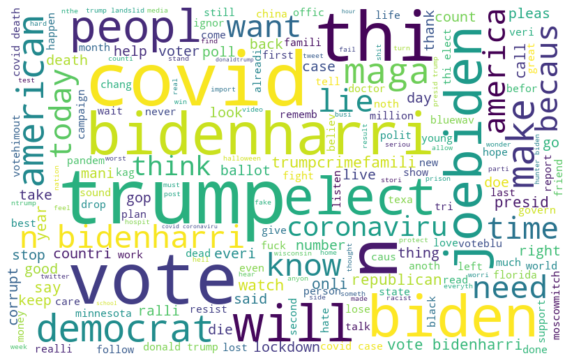

In [99]:
def plot_wordCloud_US(words):
    wordcloud = WordCloud(width=800, height=500, background_color='grey', random_state=21, max_font_size=110).generate(words)

    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    
all_words_US = ' '.join([text for text in df_US['clean_tweet']])
plot_wordCloud(all_words_US)   

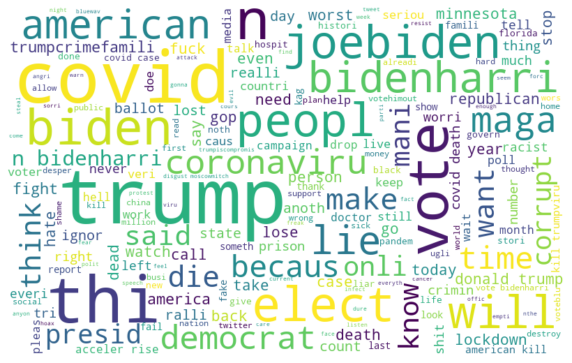

In [100]:
# Negative tweet
neg_word_US =' '.join([text for text in df_US['clean_tweet'][df_US['sentiment'] == 0]])
plot_wordCloud(neg_word_US)

#### Negative tweet includes mainly two major features that is Trump and COVID, thus proving that the election is getting affected due to these two factors and people are not happy over current administration taking COVID as reason

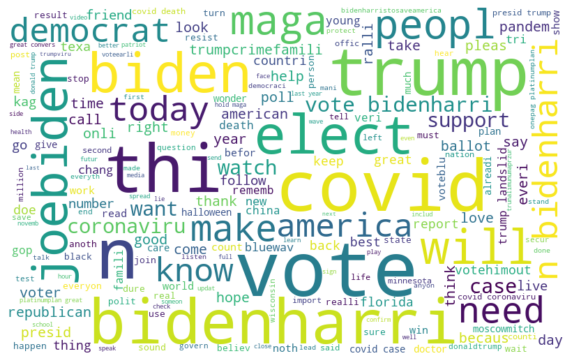

In [114]:
# Positive tweet
pos_word_US =' '.join([text for text in df_US['clean_tweet'][df_US['sentiment'] == 1]])
plot_wordCloud(pos_word_US)

#### Positive tweet includes mainly two major features that is bidenharris and vote thus provoking people to change the current government

In [64]:
#Hashtag Analysis

def hashtag_extract_US(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

# extracting hashtags from racist tweets

HT_neg_US = hashtag_extract_US(df_US['clean_tweet'][df_US['sentiment'] == 0])

# extracting hashtags from non racist tweets
HT_pos_US = hashtag_extract_US(df_US['clean_tweet'][df_US['sentiment'] == 1])

# unnesting list
HT_neg_US = sum(HT_neg_US,[])
HT_pos_US = sum(HT_pos_US,[])

[Text(0.5, 1.0, 'Negative Tweets')]

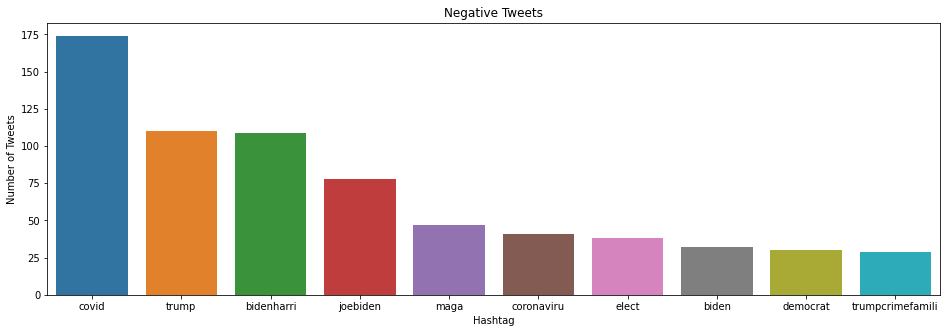

In [65]:
# Negative tweet
a_US = nltk.FreqDist(HT_neg_US)
d_US = pd.DataFrame({'Hashtag': list(a_US.keys()),
                  'Count': list(a_US.values())})

# selecting top 10 most frequent hashtags     
d_US = d_US.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d_US, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Number of Tweets')
ax.set(title = 'Negative Tweets')

#### As mentioned earlier, COVID is main reason followed by Trump as the negative sentiment, reflecting people are not happy

[Text(0.5, 1.0, 'Positive Tweets')]

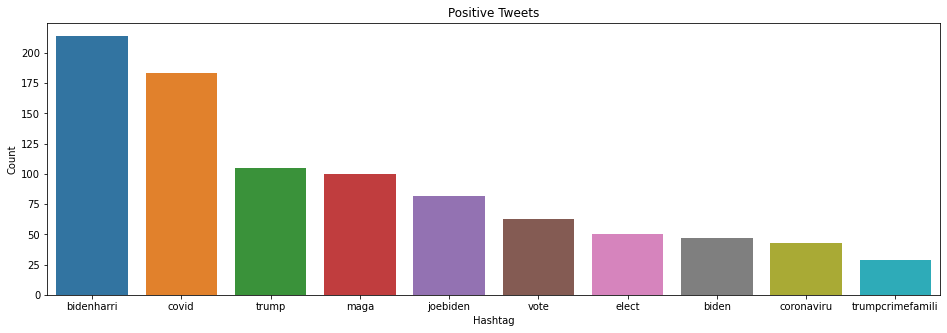

In [66]:
# Positive tweets
b_US = nltk.FreqDist(HT_pos_US)
e_US = pd.DataFrame({'Hashtag': list(b_US.keys()), 'Count': list(b_US.values())})

# selecting top 10 most frequent hashtags
e_US = e_US.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e_US, x= "Hashtag", y = "Count")
ax.set(title = 'Positive Tweets')

#### Joe Bidden and Kamla Harris from Democrats is creating very positive impression on the people sentiment creating huge oppurtunities to form their government

### Concluding from the above graphs: Bidenharris is being the most positive sentiment and COVID being the most negative sentiment. After COVID, its Trump name that is most negatively talked about. Extracting conclusion from the plots which makes sure that Joe Bidden and Kamla Harris is giving positive impact on the US election, thus giving Democrats a very positive sign to win the election and COVID being the reason for the downfall of Republican.

### Bag Of Word Feature Extraction



In [67]:
# Extracting features from the test data through BOW procedure
bow_vectorizer_US = CountVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')
bow_US = bow_vectorizer_US.fit_transform(df_US['clean_tweet'])

## Implementing Best Model- Random Forest

In [68]:
# Assigning the test data set name
test_bow = bow_US

In [69]:
# Assigning and realligning the features to implement on the best model selected from the training data set
xvalid_bow=test_bow
xtrain_bow=xtrain_bow[:2552:,:]
yvalid=yvalid[:2552]
ytrain=ytrain[:2552]


rf_bow = RandomForestClassifier(criterion= 'entropy', min_samples_leaf= 1, min_samples_split=7, n_estimators= 30, n_jobs= -1, random_state= 123).fit(xtrain_bow, ytrain)
predict_rf_bow = rf_bow.predict(xvalid_bow)

print(metrics.classification_report(yvalid, predict_rf_bow))
print ('confusion matrix')
print (confusion_matrix(yvalid,predict_rf_bow))

              precision    recall  f1-score   support

           0       0.16      0.44      0.23       389
           1       0.85      0.59      0.70      2163

    accuracy                           0.57      2552
   macro avg       0.51      0.51      0.47      2552
weighted avg       0.75      0.57      0.63      2552

confusion matrix
[[ 170  219]
 [ 891 1272]]


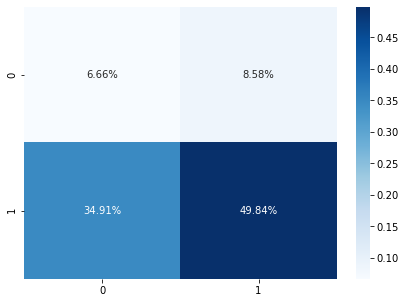

In [115]:
confusion_matrix_bm=metrics.confusion_matrix(yvalid,predict_rf_bow)
plt.figure(figsize=(7,5))
plot = sns.heatmap(confusion_matrix_bm/np.sum(confusion_matrix_bm), annot=True, fmt = '.2%',cmap='Blues')

### Got the accuracy rate of 57% on the testing data, further the confusion matrix and the heat map suggest that the maximum weigthage lies into the True Positive section.

In [70]:
# Performing hyperpararmtere tuning

#hyper parameters set
params = {'criterion':['gini','entropy'],
          'n_estimators':[10,15,20,25,30],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7], 
          'random_state':[123],
          'n_jobs':[-1]}

#Making models with hyper parameters sets
rf_bow_test_tune = GridSearchCV(rf_bow, param_grid=params, n_jobs=-1)

#learning
rf_bow_test_tune.fit(xtrain_bow, ytrain)

#The best hyper parameters set
print("Best Hyper Parameters:\n",rf_bow_test_tune.best_params_)

#Prediction
predict_rf_test_tune=rf_bow_test_tune.predict(xvalid_bow)

#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(yvalid, predict_rf_test_tune))

#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(yvalid,predict_rf_test_tune))

Best Hyper Parameters:
 {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 25, 'n_jobs': -1, 'random_state': 123}
Accuracy: 0.5658307210031348
Confusion Metrix:
 [[ 166  223]
 [ 885 1278]]


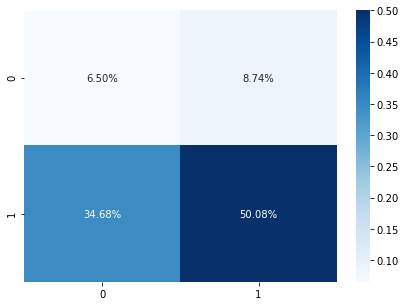

In [95]:
confusion_matrix=metrics.confusion_matrix(yvalid,predict_rf_test_tune)
plt.figure(figsize=(7,5))
plot = sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt = '.2%',cmap='Blues')

### Got the accuracy rate of ~57% on the testing data as nothing much is changing wrt tuning of data. Further the confusion matrix and the heat map suggest that the maximum weightage lies into the True Positive section thus reflecting that most of the prediction for the positive sentiment is correct. The reason being the initial training data which has maximum positive tweets which trained the model to execute effectively on the positive sentiment data.

## Negative Sentiment Dataset: 2020 US Election

In [71]:
# Dataframe for the negative tweet
df_US_neg=df_US[(df_US['sentiment'] == 0)] # Only selecting the negative sentiment out of whole test dataset
df_US_neg.head(7)

,text,sentiment,negative_reason,clean_tweet
0,"b'@robreiner so afraid of Nov, Dec, and Jan! Even if #BidenHarris2020 win...frump has 3 months to do even more damage than he has.'",0,covid19,afraid even #bidenharri frump month even more damag than
1,"b""RT @SueC00K: Lord Sumption launches Recovery - a new initiative to promote #AnotherWay to deal with #Covid. Hysteria and rushed laws",0,others,lord sumption launch recoveri initi promot #anotherway deal with #covid hysteria rush law
2,"b'RT @WalidPhares: Uber Timing: after #Biden advisors said they would put pressure on #Brazil &amp; sanction @jairbolsonaro Gov ""when"" elected,",0,covid19,uber time after #biden advisor said they would pressur #brazil sanction when elect
5,accelerating. &amp; rising when all #Americans killed by #TrumpVirus are https://t.co/QtpgvKI2vp',0,discrimination,acceler rise when #american kill #trumpviru qtpgvki
6,b'@realDonaldTrump 961 dead Americans in one day! 240 times the number who died after Benghazi. The right lost https://t.co/ES4zk2Mm68',0,discrimination,dead american time number die after benghazi right lost
8,b'@charliekirk11 only reason @realdonaldtrump is doing more than 3 rallies is because he knows he is losing https://t.co/viWWFOCE4w',0,corruption,onli reason do more than ralli becaus know lose viwwfoc
9,"b""RT @JoeBarri: Anyone who's concerned in the least about #HunterBiden is a Trump ass-kisser &amp; human fraud. WTF about the CURRENT",0,covid19,anyon concern least about #hunterbiden trump kisser human fraud about current


In [72]:
df_US_neg.info() # getting infomration of the dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264 entries, 0 to 2550
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             1264 non-null   object
 1   sentiment        1264 non-null   int64 
 2   negative_reason  1264 non-null   object
 3   clean_tweet      1264 non-null   object
dtypes: int64(1), object(3)
memory usage: 49.4+ KB


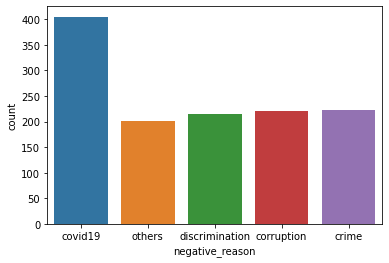

In [73]:
#Plotting graph from the dataframe with neg tweet
sns.countplot(x = 'negative_reason', data = df_US_neg)

In [74]:
# types of features in the negative_reason
df_US_neg.negative_reason.unique()

array(['covid19', 'others', 'discrimination', 'corruption', 'crime'],
      dtype=object)

In [75]:
# Assigning encoded value to each negative reason
neg_encode={'covid19':1, 'others':2, 'discrimination':3, 'corruption':4, 'crime':5}

In [76]:
#Label Encoding the target variable
df_US_neg.loc[0:,'neg_reason_Encoded'] = df_US_neg.loc[1:,'negative_reason'].map(neg_encode)
#df_US_neg.loc[1:,'neg_reason_Encoded']= df_US_neg.loc[1:,'negative_reason_Encoded'].astype(int)
df_US_neg.neg_reason_Encoded.unique()
df_US_neg.head(7)

,text,sentiment,negative_reason,clean_tweet,neg_reason_Encoded
0,"b'@robreiner so afraid of Nov, Dec, and Jan! Even if #BidenHarris2020 win...frump has 3 months to do even more damage than he has.'",0,covid19,afraid even #bidenharri frump month even more damag than,NaN
1,"b""RT @SueC00K: Lord Sumption launches Recovery - a new initiative to promote #AnotherWay to deal with #Covid. Hysteria and rushed laws",0,others,lord sumption launch recoveri initi promot #anotherway deal with #covid hysteria rush law,2.0
2,"b'RT @WalidPhares: Uber Timing: after #Biden advisors said they would put pressure on #Brazil &amp; sanction @jairbolsonaro Gov ""when"" elected,",0,covid19,uber time after #biden advisor said they would pressur #brazil sanction when elect,1.0
5,accelerating. &amp; rising when all #Americans killed by #TrumpVirus are https://t.co/QtpgvKI2vp',0,discrimination,acceler rise when #american kill #trumpviru qtpgvki,3.0
6,b'@realDonaldTrump 961 dead Americans in one day! 240 times the number who died after Benghazi. The right lost https://t.co/ES4zk2Mm68',0,discrimination,dead american time number die after benghazi right lost,3.0
8,b'@charliekirk11 only reason @realdonaldtrump is doing more than 3 rallies is because he knows he is losing https://t.co/viWWFOCE4w',0,corruption,onli reason do more than ralli becaus know lose viwwfoc,4.0
9,"b""RT @JoeBarri: Anyone who's concerned in the least about #HunterBiden is a Trump ass-kisser &amp; human fraud. WTF about the CURRENT",0,covid19,anyon concern least about #hunterbiden trump kisser human fraud about current,1.0


#### Feature selecting - BOW

In [77]:
# Feature selecting from the negative sentiment only
bow_vectorizer_US_neg = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow_US_neg = bow_vectorizer_US_neg.fit_transform(df_US_neg['clean_tweet'])

### Model Implementation

In [78]:
X=bow_US_neg # Training features
y=df_US_neg[['negative_reason']] # Target features

# splitting data into training and validation set
X_train_US, X_test_US, y_train_US, y_test_US = train_test_split(X, y,  
                                                          random_state=0, 
                                                          test_size=0.3)

In [79]:
X_train_US.shape

(884, 1000)

In [80]:
X_test_US.shape

(380, 1000)

#### 3 models/classifier selected, i.e., K-NN, Random Forest and Decision Tree

### 1. K-NN

In [81]:
from sklearn.neighbors import KNeighborsClassifier

# Applying the same code as of prior training dataset

knn_bow_US_neg = KNeighborsClassifier().fit(X_train_US, y_train_US)

predict_knn_US_neg = knn_bow_US_neg.predict(X_test_US)

print(metrics.classification_report(y_test_US, predict_knn_US_neg))


conf_matrix_KNN=confusion_matrix(y_test_US,predict_knn_US_neg)

print ('confusion matrix')
print (confusion_matrix(y_test_US,predict_knn_US_neg))

                precision    recall  f1-score   support

    corruption       0.16      0.48      0.24        62
       covid19       0.30      0.27      0.28       126
         crime       0.29      0.12      0.17        77
discrimination       0.14      0.10      0.12        49
        others       0.31      0.06      0.10        66

      accuracy                           0.22       380
     macro avg       0.24      0.21      0.18       380
  weighted avg       0.26      0.22      0.20       380

confusion matrix
[[30 16  5  8  3]
 [65 34  9 16  2]
 [33 29  9  3  3]
 [26 12  5  5  1]
 [32 24  3  3  4]]


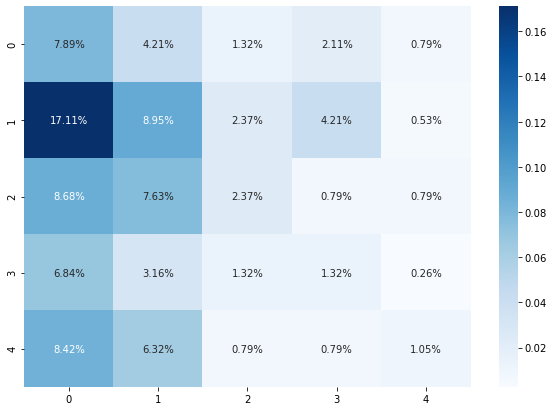

In [82]:
# Plotting Heatmap for the confusion matrix
plt.figure(figsize=(10,7))
plot = sns.heatmap(conf_matrix_KNN/np.sum(conf_matrix_KNN), annot=True, fmt = '.2%',cmap='Blues')

#### Hyperparameter Tuning

In [83]:
#importing modules
from sklearn.model_selection import GridSearchCV

#making the instance
knn_bow_US_neg = KNeighborsClassifier(n_jobs=-1)

#Hyper Parameters Set
params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}

#Making models with hyper parameters sets
knn_bow_US_neg_tune = GridSearchCV(knn_bow_US_neg, param_grid=params, n_jobs=1)

#Learning
knn_bow_US_neg_tune.fit(X_train_US, y_train_US)

#The best hyper parameters set
print("Best Hyper Parameters:\n",knn_bow_US_neg_tune.best_params_)

#Prediction
predict_knn_US_neg_tune=knn_bow_US_neg_tune.predict(X_test_US)

#importing the metrics module
from sklearn import metrics

#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(predict_knn_US_neg_tune,y_test_US))

#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(predict_knn_US_neg_tune,y_test_US))

Best Hyper Parameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}
Accuracy: 0.2631578947368421
Confusion Metrix:
 [[23 42 15 12 17]
 [20 51 39 24 37]
 [ 1 10 13  2  3]
 [12 20  8  8  4]
 [ 6  3  2  3  5]]


### 2. Random Forest

In [84]:
rf_bow_US_neg = RandomForestClassifier(n_estimators=400, random_state=11).fit(X_train_US, y_train_US)

predict_rf_US_neg = rf_bow_US_neg.predict(X_test_US)

print(metrics.classification_report(y_test_US, predict_rf_US_neg))

conf_matrix_rf=confusion_matrix(y_test_US,predict_rf_US_neg)
print ('confusion matrix')
print (confusion_matrix(y_test_US,predict_rf_US_neg))

                precision    recall  f1-score   support

    corruption       0.22      0.21      0.21        62
       covid19       0.38      0.49      0.43       126
         crime       0.36      0.31      0.33        77
discrimination       0.24      0.24      0.24        49
        others       0.29      0.18      0.22        66

      accuracy                           0.32       380
     macro avg       0.30      0.29      0.29       380
  weighted avg       0.32      0.32      0.31       380

confusion matrix
[[13 21  9  9 10]
 [28 62 17 11  8]
 [ 5 30 24 11  7]
 [ 3 22  8 12  4]
 [10 29  9  6 12]]


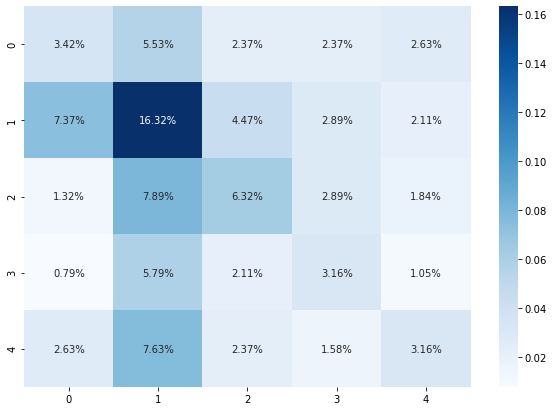

In [85]:
# Plotting Heatmap for the confusion matrix
plt.figure(figsize=(10,7))
plot = sns.heatmap(conf_matrix_rf/np.sum(conf_matrix_rf), annot=True, fmt = '.2%',cmap='Blues')

#### Hyperparameter Tuning

In [86]:
#making the instance
rf_bow_US_neg=RandomForestClassifier()
#hyper parameters set
params = {'criterion':['gini','entropy'],
          'n_estimators':[10,15,20,25,30],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7], 
          'random_state':[123],
          'n_jobs':[-1]}
#Making models with hyper parameters sets
rf_bow_US_neg_tune = GridSearchCV(rf_bow_US_neg, param_grid=params, n_jobs=-1)
#learning
rf_bow_US_neg_tune.fit(X_train_US, y_train_US)
#The best hyper parameters set
print("Best Hyper Parameters:\n",rf_bow_US_neg_tune.best_params_)
#Prediction
predict_rf_US_neg_tune=rf_bow_US_neg_tune.predict(X_test_US)

#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(predict_rf_US_neg_tune,y_test_US))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(predict_rf_US_neg_tune,y_test_US))

Best Hyper Parameters:
 {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 30, 'n_jobs': -1, 'random_state': 123}
Accuracy: 0.3394736842105263
Confusion Metrix:
 [[11 13  6  1  7]
 [31 83 47 28 43]
 [ 5 12 14  2  5]
 [ 7  8  5 12  2]
 [ 8 10  5  6  9]]


### 3. Decision Tree

In [87]:
from sklearn import tree

dt_bow_US_neg = tree.DecisionTreeClassifier().fit(X_train_US, y_train_US)

predict_dt_US_neg = dt_bow_US_neg.predict(X_test_US)

print(metrics.classification_report(y_test_US, predict_dt_US_neg))

conf_matrix_DT=confusion_matrix(y_test_US,predict_dt_US_neg)
print ('confusion matrix')
print (confusion_matrix(y_test_US,predict_dt_US_neg))

                precision    recall  f1-score   support

    corruption       0.19      0.24      0.21        62
       covid19       0.34      0.33      0.33       126
         crime       0.32      0.25      0.28        77
discrimination       0.21      0.33      0.25        49
        others       0.23      0.15      0.18        66

      accuracy                           0.27       380
     macro avg       0.26      0.26      0.25       380
  weighted avg       0.27      0.27      0.27       380

confusion matrix
[[15 19  6 12 10]
 [36 41 19 20 10]
 [11 21 19 18  8]
 [ 4 17  7 16  5]
 [13 24  8 11 10]]


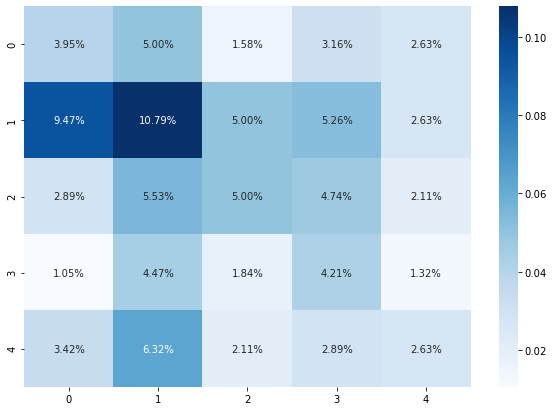

In [88]:
# Plotting Heatmap for the confusion matrix
plt.figure(figsize=(10,7))
plot = sns.heatmap(conf_matrix_DT/np.sum(conf_matrix_DT), annot=True, fmt = '.2%',cmap='Blues')

In [89]:
#making the instance
dt_bow_US_neg= tree.DecisionTreeClassifier(random_state=1234)

#Hyper Parameters Set
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[123]}

#Making models with hyper parameters sets
dt_bow_US_neg_tune = GridSearchCV(dt_bow_US_neg, param_grid=params, n_jobs=-1)

#Learning
dt_bow_US_neg_tune.fit(X_train_US, y_train_US)

#The best hyper parameters set
print("Best Hyper Parameters:",dt_bow_US_neg_tune.best_params_)

#Prediction
predict_dt_US_neg_tune=dt_bow_US_neg_tune.predict(X_test_US)

#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(predict_dt_US_neg_tune,y_test_US))

#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(predict_dt_US_neg_tune,y_test_US))

Best Hyper Parameters: {'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 2, 'random_state': 123}
Accuracy: 0.3447368421052632
Confusion Metrix:
 [[  1   0   0   0   0]
 [ 57 123  72  42  64]
 [  0   0   0   0   0]
 [  4   3   5   7   2]
 [  0   0   0   0   0]]


### Concluding out of three models the best model with maximum accuracy of 34.4% is Random Forest after performing the hypermarameter tuning.


## Conclusions:


#### 1. Understanding the first model and its result, it can be seen that the True Positive Value is occupying the maximum percentage thus reflecting that the positive sentiment is on the much higher side. Also we did the the EDA, then we found that the negative sentiments word of clouds is comprising of the words like Trump which indicated that the people are not happy with the Trump administration.

#### 2.  The word of clouds also mentions some major negative words as of Kill which may be the reflection of the black community being targeted or killed thus creating the negative impression on the Trump administration.

#### 3. Republic party is getting some bad impression while the Democrat party is in advantage due to COVID mishandling as this comes by analysis of the test data set. Joe Biden and Kamla Harris combined hashtag "bidenharris" is in major proportion in positive sentiments values while Trump and COVID is in major negative sentiment values.

#### 4. Understanding the second model and its result, it can be seen the selected model predicted an accuracy of ~34% while COVID is comprising of maximum weightage in the confusion matrix ~18%. So, behind the negative sentiment COVID is the major reason followed by crime and discriminations.

#### 5. NLP or Natural language Processing either through tweeter or any social media platform gives a great idea to analyze the sentiment of the large demography across any given region, thus helps to predict possible correct consequences of any upcoming event.

#### 6.  So answering the research question: The Democrats will be in major advantage and the Republican will probably loose the coming election due to hurting the sentiment of the people because of mishandling of COVID and other racial injustices.

#### 7. Second model approximately able to predict the correct reason behind the negative sentiment. Referring the negative hashtag graph above, COVID is the main reason for the negative sentiment while the model also predicted the higher proportion for the COVID in the heat map.

#### 8. First model accuracy can be improved by considering the larger training dataset with approximately equal number of both positive and negative sentiment  data so that it can train the model well with respect to both sentiments. In above selected training set, the major proportion is positive sentiment thus affecting the accuracy of the test data set. Second model accuracy can be improved by taking more rows on the training set data.
